# Convolutional Neural Networks


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets


In [49]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("C:/Users/daisu/OneDrive/Desktop/Dog-Project/humanImages/*/*/*"))
dog_files = np.array(glob("C:/Users/daisu/OneDrive/Desktop/Dog-Project/dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


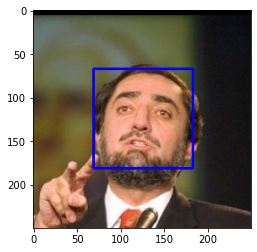

In [50]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('C:/Users/daisu/OneDrive/Desktop/Dog-Project/haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[23])

# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0), 2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

### Write a Human Face Detector


In [51]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector


In [52]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_count = [1 for i in range(100) if face_detector(human_files_short[i])]
dog_count = [1 for i in range(100) if face_detector(dog_files_short[i])]

print(f"Classified correctly: {sum(human_count) / 100}%")
print(f"Classified wrongly: {sum(dog_count) / 100}%")

Classified correctly: 0.96%
Classified wrongly: 0.18%


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model


In [53]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In [54]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    # Pre-process
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    # Open the image and apply the transformation process
    img = Image.open(img_path)
    img = transform(img)
    img = img.unsqueeze(0)
    
    if use_cuda:
        img = img.cuda()
    
    # Pass the pre-processed image as an input to the model and do the prediction
    VGG16.eval()
    prediction = VGG16(img)
    
    # Get the class index with the highest probability
    return torch.max(prediction,1)[1].item() # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

In [55]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    index = VGG16_predict(img_path)
    
    if index in range(151, 269):
        return True # true/false
    return False

### (IMPLEMENTATION) Assess the Dog Detector

In [56]:
def asses_dog_detector(files_paths):
    total = len(files_paths)
    count = 0
    for img_path in files_paths:
        if dog_detector(img_path):
            count += 1
    return count, total


count, total = asses_dog_detector(dog_files_short)
print(f"Classified correctly: {(count/total)*100}%")

count, total = asses_dog_detector(human_files_short)
print(f"Classified wrongly: {(count/total)*100}%")

Classified correctly: 94.0%
Classified wrongly: 0.0%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

In [58]:
import os
from torchvision import datasets
import torchvision.transforms as transforms
import torch
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# Batch size
batch_size = 20
num_workers = 0

# Directorys
data_dir = 'C:/Users/daisu/OneDrive/Desktop/Dog-Project/dogImages/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

# Pre-process
data_transforms = {
    
                    'train':transforms.Compose([transforms.Resize(256),
                                               transforms.RandomResizedCrop(224),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
    
                   'valid':transforms.Compose([transforms.Resize(256),
                                               transforms.CenterCrop(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),

                   'test':transforms.Compose([transforms.Resize(256),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
                  }


train_data = datasets.ImageFolder(train_dir, transform = data_transforms['train'])
valid_data = datasets.ImageFolder(valid_dir, transform = data_transforms['valid'])
test_data = datasets.ImageFolder(test_dir, transform = data_transforms['test'])


trainloader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, num_workers = num_workers, shuffle = False)
testloader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers, shuffle = False)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [60]:
import torch.nn as nn
import torch.nn.functional as F

num_classes = 133

# define the CNN architecture
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        ## CNN
        self.conv1 = nn.Conv2d(3, 32, 3, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
        
        # Pooling 
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully-connected 
        self.fc1 = nn.Linear(7 * 7 * 128, 500)
        self.fc2 = nn.Linear(500, num_classes)
        
        #Dropout
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 7 * 7 * 128)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    
print(model_scratch)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [62]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [63]:
def train(n_epochs, trainloader, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(trainloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # Clear the gradients
            optimizer.zero_grad()
            # Forward pass
            output = model(data)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Backward pass
            loss.backward()
            # Update the weights 
            optimizer.step()
            # Update the training loss
            train_loss += loss.item() * data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(validloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
            # Forward pass
            output = model(data)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Update the validation loss
            valid_loss += loss.item() * data.size(0)

            
        # Average of train and valid losses
        train_loss = train_loss / len(trainloader.dataset)
        valid_loss = valid_loss / len(trainloader.dataset)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).    Saving model...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [64]:
# train the model
n_epochs = 20
model_scratch = train(n_epochs, trainloader, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.879986 	Validation Loss: 0.607401
Validation loss decreased (inf --> 0.607401).    Saving model...
Epoch: 2 	Training Loss: 4.851151 	Validation Loss: 0.601960
Validation loss decreased (0.607401 --> 0.601960).    Saving model...
Epoch: 3 	Training Loss: 4.793367 	Validation Loss: 0.590450
Validation loss decreased (0.601960 --> 0.590450).    Saving model...
Epoch: 4 	Training Loss: 4.754885 	Validation Loss: 0.583196
Validation loss decreased (0.590450 --> 0.583196).    Saving model...
Epoch: 5 	Training Loss: 4.720394 	Validation Loss: 0.576325
Validation loss decreased (0.583196 --> 0.576325).    Saving model...
Epoch: 6 	Training Loss: 4.649211 	Validation Loss: 0.563427
Validation loss decreased (0.576325 --> 0.563427).    Saving model...
Epoch: 7 	Training Loss: 4.589399 	Validation Loss: 0.557365
Validation loss decreased (0.563427 --> 0.557365).    Saving model...
Epoch: 8 	Training Loss: 4.551725 	Validation Loss: 0.551967
Validation loss decreased (

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [66]:
def test(testloader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(testloader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [67]:
test(testloader, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.053239


Test Accuracy:  9% (83/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [68]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 

# Loading VGG16
model_transfer = models.vgg16(pretrained = True)

# Freezing the pre-trained parameters
for param in model_transfer.features.parameters():
    param.requires_grad = False

# Input size of the last layer
input_size = model_transfer.classifier[6].in_features

# Change the last layer to predict the breeds
model_transfer.classifier[6] = nn.Linear(input_size, 133)

if use_cuda:
    model_transfer = model_transfer.cuda()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [69]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [70]:
n_epochs = 20

# train the model
model_transfer = train(n_epochs, trainloader, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.075915 	Validation Loss: 0.083572
Validation loss decreased (inf --> 0.083572).    Saving model...
Epoch: 2 	Training Loss: 1.170167 	Validation Loss: 0.065706
Validation loss decreased (0.083572 --> 0.065706).    Saving model...
Epoch: 3 	Training Loss: 1.026966 	Validation Loss: 0.057935
Validation loss decreased (0.065706 --> 0.057935).    Saving model...
Epoch: 4 	Training Loss: 0.984650 	Validation Loss: 0.061112
Epoch: 5 	Training Loss: 0.891239 	Validation Loss: 0.053177
Validation loss decreased (0.057935 --> 0.053177).    Saving model...
Epoch: 6 	Training Loss: 0.888473 	Validation Loss: 0.052823
Validation loss decreased (0.053177 --> 0.052823).    Saving model...
Epoch: 7 	Training Loss: 0.862143 	Validation Loss: 0.053492
Epoch: 8 	Training Loss: 0.844768 	Validation Loss: 0.050984
Validation loss decreased (0.052823 --> 0.050984).    Saving model...
Epoch: 9 	Training Loss: 0.796807 	Validation Loss: 0.060153
Epoch: 10 	Training Loss: 0.787755 	

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [71]:
test(testloader, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.449277


Test Accuracy: 86% (719/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [72]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in trainloader.dataset.classes]


def load_image(img_path):
    # Pre-process
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    # Open the image and apply the transformation process
    img = Image.open(img_path)
    img = transform(img)
    img = img.unsqueeze(0)
    
    return img
    
def predict_breed_transfer(img_path, model, class_names):
    # Load the image and return the prediction
    img = load_image(img_path)
    
    if use_cuda:
        img = img.cuda()
        model = model.cuda()
        
    # Pass the pre-processed image as an input to the model and do the prediction
    model.eval()
    prediction = model(img)
    
    # Get the class index with the highest probability
    index = torch.max(prediction,1)[1].item() # predicted class index
    
    return class_names[index]

In [73]:
predict_breed_transfer('./images/Welsh_springer_spaniel_08203.jpg', model_transfer, class_names)

'Irish red and white setter'

---
<a id='step5'></a>
## Step 5: Write your Algorithm


### (IMPLEMENTATION) Write your Algorithm

In [74]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    img = Image.open(img_path)
    plt.imshow(img)
    
    if dog_detector(img_path):
        prediction = predict_breed_transfer(img_path, model_transfer, class_names)
        print("\n\n I'm a dog")
        plt.show()
        print(f"I'm like ...\n{prediction}")
        
    elif face_detector(img_path):
        prediction = predict_breed_transfer(img_path, model_transfer, class_names)
        print("\n\n I'm a human")
        plt.show()
        print(f"I'm like  ...\n{prediction}")
    else:
        print("\n\n I am not human nor dog, I'm new species")
        plt.show()
        print("Therefore, No one ever categorized me")

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!




 I am not human nor dog, I'm new species


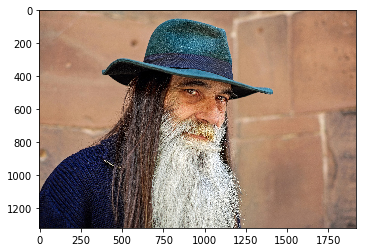

Therefore, No one ever categorized me


 I'm a human


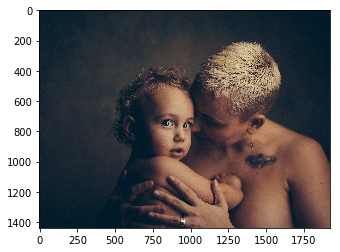

I'm like  ...
Afghan hound


 I'm a human


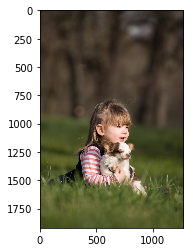

I'm like  ...
English springer spaniel


 I'm a dog


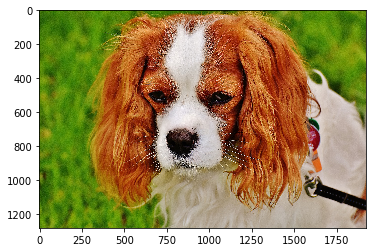

I'm like ...
Cavalier king charles spaniel


 I'm a dog


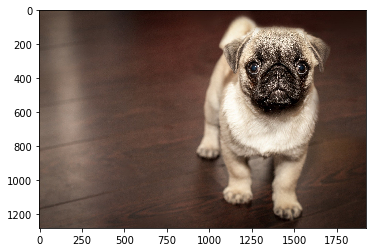

I'm like ...
Pekingese


 I am not human nor dog, I'm new species


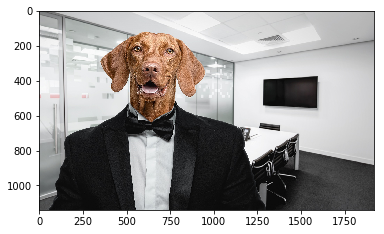

Therefore, No one ever categorized me


In [77]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

my_human_files = ['./my_images/human/human-1411499_1920.jpg', './my_images/human/love-3315769_1920.jpg',  './my_images/newspecies/girl-5231971_1920.jpg']
my_dog_files = ['./my_images/dog/dog-1606600_1920.jpg', './my_images/dog/pug-690566_1920.jpg']
my_newspecies_files = ['./my_images/newspecies/dog-3822183_1920.jpg']
## suggested code, below
for file in np.hstack((my_human_files, my_dog_files, my_newspecies_files)):
    run_app(file)